In [4]:
import sys

sys.path.append("/home/filip/samsara/elysium/externals/Noresqa")

import torch
import argparse
import librosa
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
from model import NORESQA
from scipy import signal
import glob
import ntpath

In [5]:
device = torch.device("cuda:{}".format(0))
model = NORESQA()
model.to(device)
model.eval()

NORESQA(
  (base_encoder): base_encoder(
    (modelA): model_dimred(
      (modules1): ModuleList(
        (0): Conv2d(2, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(2, 24, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Conv2d(2, 16, kernel_size=(1, 1), stride=(1, 1))
        (4): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (5): MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=1, ceil_mode=False)
        (6): Conv2d(2, 8, kernel_size=(1, 1), stride=(1, 1))
        (7): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
      )
    )
    (modelB): model_dimred(
      (modules1): ModuleList(
        (0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(64, 24, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Conv2d

In [6]:
def extract_stft(audio, sampling_rate = 16000):

    f, t, Sxx = signal.stft(audio, sampling_rate, window='hann',nperseg=512,noverlap=256,nfft=512)
    Sxx = Sxx[:256,:]

    feat = np.concatenate((np.abs(Sxx).reshape([Sxx.shape[0],Sxx.shape[1],1]), np.angle(Sxx).reshape([Sxx.shape[0],Sxx.shape[1],1])), axis=2)

    return feat 

# function doing prediction
def model_prediction(test_feat, nmr_feat):

    intervals_sdr = np.arange(0.5,40,1) 

    with torch.no_grad():
        
        ranking_frame,sdr_frame,snr_frame = model(test_feat.permute(0,3,2,1),nmr_feat.permute(0,3,2,1))
        # preference task prediction
        
        ranking = sfmax(ranking_frame).mean(2).detach().cpu().numpy()
        pout = ranking[0][0]

        # quantification task
        sdr = intervals_sdr * (sfmax(sdr_frame).mean(2).detach().cpu().numpy())
        qout = sdr.sum()

    return pout, qout

# function checking if the size of the inputs are same. If not, then the reference audio's size is adjusted
def check_size(audio_ref,audio_test):
    
    if len(audio_ref) > len(audio_test):
        print('Durations dont match. Adjusting duration of reference.')
        audio_ref = audio_ref[:len(audio_test)]
        
    elif len(audio_ref) < len(audio_test):
        print('Durations dont match. Adjusting duration of reference.')
        while len(audio_test) > len(audio_ref):
            audio_ref = np.append(audio_ref, audio_ref)
        audio_ref = audio_ref[:len(audio_test)] 
    
    return audio_ref, audio_test

# reading audio clips
def audio_loading(path,sampling_rate=16000):

    audio, fs = librosa.load(path)
    if len(audio.shape) > 1:
        audio = librosa.to_mono(audio)

    if fs != sampling_rate:
        audio = librosa.resample(audio,fs,sampling_rate)

    return audio

# top level function combining loading, and feature extraction
def feats_loading(ref_path,test_path):
    
    audio_ref = audio_loading(ref_path)
    audio_test = audio_loading(test_path)

    audio_ref, audio_test = check_size(audio_ref,audio_test)

    ref_feat = extract_stft(audio_ref)
    test_feat = extract_stft(audio_test)

    return ref_feat,test_feat

def inference_file(nmr,test_file):
    nmr_feat,test_feat = feats_loading(nmr,test_file)
    test_feat = torch.from_numpy(test_feat).float().to(device).unsqueeze(0)
    nmr_feat = torch.from_numpy(nmr_feat).float().to(device).unsqueeze(0)

    return model_prediction(test_feat,nmr_feat)

In [7]:
#feats_loading('/work/data/timit/data/TEST/DR1/FAKS0/SI943.WAV',
#glob.glob("/work/data/speech_metrics_eval/TencentCorups/withReverberationTrainDev/*")[0])

In [8]:
import sys

sys.path.append("/home/filip/samsara/elysium/externals/Noresqa")

import torch
import argparse
import librosa as librosa
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
from model import NORESQA
from scipy import signal
import glob
import ntpath

model = NORESQA()

# Loading checkpoint
model_checkpoint_path = './externals/metrics/Noresqa/models/model_noresqa_mos.pth'
state = torch.load(model_checkpoint_path,map_location="cpu")['state_base']

pretrained_dict = {}
for k, v in state.items():
    if 'module' in k:
        pretrained_dict[k.replace('module.','')]=v
    else:
        pretrained_dict[k]=v
model_dict = model.state_dict()
model_dict.update(pretrained_dict)
model.load_state_dict(pretrained_dict)

# device
device = torch.device("cuda:{}".format(0))

model.to(device)
model.eval()

sfmax = nn.Softmax(dim=1)

# function extraction stft
def extract_stft(audio, sampling_rate = 16000):

    f, t, Sxx = signal.stft(audio, sampling_rate, window='hann',nperseg=512,noverlap=256,nfft=512)
    Sxx = Sxx[:256,:]

    feat = np.concatenate((np.abs(Sxx).reshape([Sxx.shape[0],Sxx.shape[1],1]), np.angle(Sxx).reshape([Sxx.shape[0],Sxx.shape[1],1])), axis=2)

    return feat 

# function doing prediction
def model_prediction(test_feat, nmr_feat):

    intervals_sdr = np.arange(0.5,40,1) 

    with torch.no_grad():
        
        ranking_frame,sdr_frame,snr_frame = model(test_feat.permute(0,3,2,1),nmr_feat.permute(0,3,2,1))
        # preference task prediction
        
        ranking = sfmax(ranking_frame).mean(2).detach().cpu().numpy()
        pout = ranking[0][0]

        # quantification task
        sdr = intervals_sdr * (sfmax(sdr_frame).mean(2).detach().cpu().numpy())
        qout = sdr.sum()

    return pout, qout

# function checking if the size of the inputs are same. If not, then the reference audio's size is adjusted
def check_size(audio_ref,audio_test):
    
    if len(audio_ref) > len(audio_test):
        print('Durations dont match. Adjusting duration of reference.')
        audio_ref = audio_ref[:len(audio_test)]
        
    elif len(audio_ref) < len(audio_test):
        print('Durations dont match. Adjusting duration of reference.')
        while len(audio_test) > len(audio_ref):
            audio_ref = np.append(audio_ref, audio_ref)
        audio_ref = audio_ref[:len(audio_test)] 
    
    return audio_ref, audio_test

# reading audio clips
def audio_loading(path,sampling_rate=16000):

    audio, fs = librosa.load(path)
    if len(audio.shape) > 1:
        audio = librosa.to_mono(audio)

    if fs != sampling_rate:
        audio = librosa.resample(audio,fs,sampling_rate)

    return audio

# top level function combining loading, and feature extraction
def feats_loading(ref_path,test_path):
    
    audio_ref = audio_loading(ref_path)
    audio_test = audio_loading(test_path)

    audio_ref, audio_test = check_size(audio_ref,audio_test)

    ref_feat = extract_stft(audio_ref)
    test_feat = extract_stft(audio_test)

    return ref_feat,test_feat

def inference_file(nmr,test_file):
    nmr_feat,test_feat = feats_loading(nmr,test_file)
    test_feat = torch.from_numpy(test_feat).float().to(device).unsqueeze(0)
    nmr_feat = torch.from_numpy(nmr_feat).float().to(device).unsqueeze(0)

    return model_prediction(test_feat,nmr_feat)

UnpicklingError: invalid load key, 'v'.

In [9]:
x1, x2 = feats_loading('/work/data/timit/data/TEST/DR1/FAKS0/SI943.WAV',
glob.glob("/work/data/speech_metrics_eval/TencentCorups/withReverberationTrainDev/*")[0])
x1 = torch.from_numpy(x1).float().to(device).unsqueeze(0)
x2 = torch.from_numpy(x2).float().to(device).unsqueeze(0)

intervals_sdr = np.arange(0.5,40,1) 

with torch.no_grad():
    
    ranking_frame,sdr_frame,snr_frame = model(x1.permute(0,3,2,1),x2.permute(0,3,2,1))
    # preference task prediction
    
    ranking = sfmax(ranking_frame).mean(2).detach().cpu().numpy()
    pout = ranking[0][0]

    # quantification task
    sdr = intervals_sdr * (sfmax(sdr_frame).mean(2).detach().cpu().numpy())
    qout = sdr.sum()

Durations dont match. Adjusting duration of reference.


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [9]:
import sys

sys.path.append("/home/filip/samsara/elysium/externals/Noresqa")

import torch
import argparse
import librosa as librosa
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
from model import NORESQA
from scipy import signal

CONFIG_PATH = 'externals/metrics/Noresqa/models/wav2vec_small.pt'
metric_type = 1
load_checkpoint = False
GPU_id = 0
# Noresqa model
model = NORESQA(40,40,1 #,CONFIG_PATH
)
if load_checkpoint:
# Loading checkpoint
    if metric_type==0:
        model_checkpoint_path = 'externals/metrics/Noresqa/models/model_noresqa.pth'
        state = torch.load(model_checkpoint_path,map_location="cpu")['state_base']
    elif metric_type == 1:
        model_checkpoint_path = 'externals/metrics/Noresqa/models/model_noresqa_mos.pth'
        state = torch.load(model_checkpoint_path,map_location="cpu")['state_dict']

    pretrained_dict = {}
    for k, v in state.items():
        if 'module' in k:
            pretrained_dict[k.replace('module.','')]=v
        else:
            pretrained_dict[k]=v
    model_dict = model.state_dict()
    model_dict.update(pretrained_dict)
    model.load_state_dict(pretrained_dict)

# change device as needed
# device
if GPU_id >=0 and torch.cuda.is_available():
    device = torch.device("cuda:{}".format(GPU_id))
else:
    device = torch.device("cpu")

model.to(device)
model.eval()

sfmax = nn.Softmax(dim=1)

In [10]:
# function extraction stft
def extract_stft(audio, sampling_rate = 16000):

    fx, tx, stft_out = signal.stft(audio, sampling_rate, window='hann',nperseg=512,noverlap=256,nfft=512)
    stft_out = stft_out[:256,:]
    feat = np.concatenate((np.abs(stft_out).reshape([stft_out.shape[0],stft_out.shape[1],1]), np.angle(stft_out).reshape([stft_out.shape[0],stft_out.shape[1],1])), axis=2)
    return feat

# noresqa and noresqa-mos prediction calls
def model_prediction_noresqa(test_feat, nmr_feat):

    intervals_sdr = np.arange(0.5,40,1)

    with torch.no_grad():
        ranking_frame,sdr_frame,snr_frame = model(test_feat.permute(0,3,2,1),nmr_feat.permute(0,3,2,1))
        # preference task prediction
        ranking = sfmax(ranking_frame).mean(2).detach().cpu().numpy()
        pout = ranking[0][0]
        # quantification task
        sdr = intervals_sdr * (sfmax(sdr_frame).mean(2).detach().cpu().numpy())
        qout = sdr.sum()

    return pout, qout

def model_prediction_noresqa_mos(test_feat, nmr_feat):

    with torch.no_grad():
        score = model(nmr_feat,test_feat).detach().cpu().numpy()[0]

    return score


# reading audio clips
def audio_loading(path,sampling_rate=16000):

    audio, fs = librosa.load(path)
    if len(audio.shape) > 1:
        audio = librosa.to_mono(audio)

    if fs != sampling_rate:
        audio = librosa.resample(audio,fs,sampling_rate)

    return audio


# function checking if the size of the inputs are same. If not, then the reference audio's size is adjusted
def check_size(audio_ref,audio_test):

    if len(audio_ref) > len(audio_test):
        print('Durations dont match. Adjusting duration of reference.')
        audio_ref = audio_ref[:len(audio_test)]

    elif len(audio_ref) < len(audio_test):
        print('Durations dont match. Adjusting duration of reference.')
        while len(audio_test) > len(audio_ref):
            audio_ref = np.append(audio_ref, audio_ref)
        audio_ref = audio_ref[:len(audio_test)]

    return audio_ref, audio_test


# audio loading and feature extraction
def feats_loading(test_path, ref_path=None, noresqa_or_noresqaMOS = 0):

    if noresqa_or_noresqaMOS == 0 or noresqa_or_noresqaMOS == 1:

        audio_ref = audio_loading(ref_path)
        audio_test = audio_loading(test_path)
        audio_ref, audio_test = check_size(audio_ref,audio_test)

        if noresqa_or_noresqaMOS == 0:
            ref_feat = extract_stft(audio_ref)
            test_feat = extract_stft(audio_test)
            return ref_feat,test_feat
        else:
            return audio_ref, audio_test

In [11]:
from externals.metrics.Noresqa.model import NORESQA
import fairseq
import torchaudio
import torch
from torch import nn
device = torch.device("cuda:{}".format(1))

In [12]:
model = NORESQA(metric_type=1,config_path="/home/filip/speech_metrics_eval/externals/metrics/Noresqa/models/wav2vec_small.pt").to(device)

/work/miniconda3/envs/sayso_dev/lib/python3.9/site-packages/hydra/core/plugins.py:202: UserWarning: 
	Error importing 'hydra_plugins.hydra_colorlog'.
	Plugin is incompatible with this Hydra version or buggy.
	Recommended to uninstall or upgrade plugin.
		ImportError : cannot import name 'SearchPathPlugin' from 'hydra.plugins' (/work/miniconda3/envs/sayso_dev/lib/python3.9/site-packages/hydra/plugins/__init__.py)
  warnings.warn(


RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [6]:
audio_test = audio_loading(df.iloc[0].path)
test_feat = extract_stft(audio_test)

NameError: name 'df' is not defined

In [ ]:
nmr_feat,test_feat = feats_loading(df.iloc[0].path, df.iloc[0].path, noresqa_or_noresqaMOS = 1)

In [ ]:
audio_test,sr = torchaudio.load(df.iloc[0].path)

In [ ]:
import gc
import torch
#del model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
torch.from_numpy(audio_test).float().to(device).unsqueeze(0).shape

torch.Size([1, 184504])

In [ ]:
audio_test.shape

torch.Size([1, 553509])

In [26]:
df.sort_values("mos")[0]

,db,con,file,con_description,filename_deg,filename_ref,source,lang,votes,mos,...,dis,loud,noi_std,col_std,dis_std,loud_std,mos_std,filepath_deg,filepath_ref,path
11670,NISQA_TRAIN_SIM,9939.0,9939.0,simulated,c09939_2_664_2_7_001-ch6-speaker_seg20.wav,2_664_2_7_001-ch6-speaker_seg20.wav,AusTalk,en,5.0,1.0,...,2.101412,1.155794,0.849365,1.422645,1.421229,0.140417,0.0,NISQA_TRAIN_SIM/deg/c09939_2_664_2_7_001-ch6-s...,NISQA_TRAIN_SIM/ref/2_664_2_7_001-ch6-speaker_...,/work/data/speech_metrics_eval/NISQA_Corpus/NI...
3684,NISQA_TRAIN_SIM,1953.0,1953.0,simulated,c01953_nom_08784_01631596649_seg.wav,nom_08784_01631596649_seg.wav,UKIRE,en,5.0,1.0,...,1.155966,3.347070,0.977778,0.747127,0.092728,1.609947,0.0,NISQA_TRAIN_SIM/deg/c01953_nom_08784_016315966...,NISQA_TRAIN_SIM/ref/nom_08784_01631596649_seg.wav,/work/data/speech_metrics_eval/NISQA_Corpus/NI...
5187,NISQA_TRAIN_SIM,3456.0,3456.0,simulated,c03456_3_775_2_7_001-ch6-speaker_seg50.wav,3_775_2_7_001-ch6-speaker_seg50.wav,AusTalk,en,4.0,1.0,...,2.050490,1.961792,1.757422,0.139913,1.217594,0.911812,0.0,NISQA_TRAIN_SIM/deg/c03456_3_775_2_7_001-ch6-s...,NISQA_TRAIN_SIM/ref/3_775_2_7_001-ch6-speaker_...,/work/data/speech_metrics_eval/NISQA_Corpus/NI...
12885,NISQA_VAL_SIM,954.0,954.0,simulated,c0954_book_09628_chp_0013_reader_05511_9_seg.wav,book_09628_chp_0013_reader_05511_9_seg.wav,DNS,en,5.0,1.0,...,3.547234,2.225848,0.892520,0.246701,1.356060,1.184918,0.0,NISQA_VAL_SIM/deg/c0954_book_09628_chp_0013_re...,NISQA_VAL_SIM/ref/book_09628_chp_0013_reader_0...,/work/data/speech_metrics_eval/NISQA_Corpus/NI...
9508,NISQA_TRAIN_SIM,7777.0,7777.0,simulated,c07777_sof_04766_00599431030_seg.wav,sof_04766_00599431030_seg.wav,UKIRE,en,5.0,1.0,...,2.246123,3.143344,0.168104,1.076841,0.716838,1.469859,0.0,NISQA_TRAIN_SIM/deg/c07777_sof_04766_005994310...,NISQA_TRAIN_SIM/ref/sof_04766_00599431030_seg.wav,/work/data/speech_metrics_eval/NISQA_Corpus/NI...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6433,NISQA_TRAIN_SIM,4702.0,4702.0,simulated,c04702_book_03865_chp_0016_reader_03497_73_seg...,book_03865_chp_0016_reader_03497_73_seg.wav,DNS,en,5.0,5.0,...,4.770335,4.493423,0.172042,0.336687,0.178099,0.367816,0.0,NISQA_TRAIN_SIM/deg/c04702_book_03865_chp_0016...,NISQA_TRAIN_SIM/ref/book_03865_chp_0016_reader...,/work/data/speech_metrics_eval/NISQA_Corpus/NI...
7970,NISQA_TRAIN_SIM,6239.0,6239.0,simulated,c06239_book_01454_chp_0004_reader_10920_1_seg.wav,book_01454_chp_0004_reader_10920_1_seg.wav,DNS,en,4.0,5.0,...,4.744082,4.224199,0.275500,0.265183,0.211983,0.524245,0.0,NISQA_TRAIN_SIM/deg/c06239_book_01454_chp_0004...,NISQA_TRAIN_SIM/ref/book_01454_chp_0004_reader...,/work/data/speech_metrics_eval/NISQA_Corpus/NI...
4637,NISQA_TRAIN_SIM,2906.0,2906.0,simulated,c02906_book_07907_chp_0003_reader_02514_11_seg...,book_07907_chp_0003_reader_02514_11_seg.wav,DNS,en,5.0,5.0,...,4.699517,4.757853,0.405287,0.304674,0.363673,0.253140,0.0,NISQA_TRAIN_SIM/deg/c02906_book_07907_chp_0003...,NISQA_TRAIN_SIM/ref/book_07907_chp_0003_reader...,/work/data/speech_metrics_eval/NISQA_Corpus/NI...
6489,NISQA_TRAIN_SIM,4758.0,4758.0,simulated,c04758_book_02922_chp_0034_reader_06496_42_seg...,book_02922_chp_0034_reader_06496_42_seg.wav,DNS,en,5.0,5.0,...,4.827712,4.837205,0.093347,0.114373,0.104091,0.098601,0.0,NISQA_TRAIN_SIM/deg/c04758_book_02922_chp_0034...,NISQA_TRAIN_SIM/ref/book_02922_chp_0034_reader...,/work/data/speech_metrics_eval/NISQA_Corpus/NI...


In [11]:
# torch.from_numpy(audio_test).float().to(device).unsqueeze(0)
t = torch.stack([torch.from_numpy(audio_test).float().to(device),torch.from_numpy(audio_test).float().to(device)])

TypeError: expected np.ndarray (got Tensor)

In [28]:
clean_audio,sr = torchaudio.load(df.sort_values("mos").iloc[0].path)
noisy_audio,sr = torchaudio.load(df.sort_values("mos").iloc[-1].path)

In [29]:
out = model(torch.stack([noisy_audio[:,:10000],noisy_audio[:,:10000]]).to(device),
torch.stack([clean_audio[:,:10000],clean_audio[:,:10000]]).to(device))

In [12]:
out = model(torch.stack([noisy_audio[:,:10000],noisy_audio[:,:10000]]).to(device),
torch.stack([clean_audio[:,:10000],clean_audio[:,:10000]]).to(device))

NameError: name 'noisy_audio' is not defined

In [7]:
tp = torch.tensor([int(df.sort_values("mos").iloc[0].mos < df.sort_values("mos").iloc[-1].mos), int(df.sort_values("mos").iloc[0].mos > df.sort_values("mos").iloc[-1].mos)])
tp = torch.stack([tp,tp])

NameError: name 'df' is not defined

In [70]:
tp

tensor([[1, 0],
        [1, 0]])

In [78]:
out[0]

tensor([2.0673, 2.0540], device='cuda:1', grad_fn=<SumBackward1>)

In [ ]:
torch.pow(out[1].cpu(),iter)

In [76]:
torch.sum(torch.pow(tp,iter) * torch.log(torch.pow(out[1].cpu(),iter)),1)

tensor([-2.4098, -2.3022], grad_fn=<SumBackward1>)

In [ ]:
torch.log(torch.pow(out[1].cpu(),iter))

In [71]:
torch.sum(torch.log(torch.pow(out[1].cpu(),iter)),1)

tensor([-6.0427, -6.1038], grad_fn=<SumBackward1>)

In [59]:
iter = torch.tensor([1.,2.])

In [58]:
torch.pow(-tp,iter)

tensor([[1., 0.],
        [1., 0.]])

In [ ]:
torch.log()

In [48]:
torch.linspace(1, 2,steps=2)#.to(concat.device)

tensor([1., 2.])

In [ ]:
def preference_loss(output_preference, true_preference):
    iter = torch.tensor([1.,2.]).to(output_preference.device)
    return torch.sum(torch.pow(true_preference,iter) * torch.log(torch.pow(output_preference,iter)),1)

In [ ]:
def relative_rating_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv("/work/data/speech_metrics_eval/NISQA_Corpus/NISQA_corpus_file.csv")

In [ ]:
import torchaudio

torchaudio.load

In [17]:
#import librosa
import torchaudio
for db_type in df["db"].unique():
    a,sr = torchaudio.load(df[df["db"] == db_type].iloc[0].path)
    print(sr)


48000
48000
48000
48000
48000
48000
48000


In [14]:
# 22050

In [11]:
dir_path = "/work/data/speech_metrics_eval/NISQA_Corpus"
df['path'] = df.apply(lambda x: f"{dir_path}/{x['db']}/deg/{x['filename_deg']}",axis=1)

In [ ]:
import os
import pandas as pd
from torch.utils.data import Dataset


class CustomImageDataset(Dataset):
    def __init__(self, entries):
        self.entries = entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries.iloc[idx]
        return image, label

In [3]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, momentum=0.9)


for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

TypeError: __init__() got an unexpected keyword argument 'momentum'

In [1]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset
import torch

# load model and tokenizer
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
    
# load dummy dataset and read soundfiles
ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")

# tokenize
input_values = processor(ds[0]["audio"]["array"], return_tensors="pt", padding="longest").input_values  # Batch size 1

# retrieve logits
logits = model(input_values).logits

# take argmax and decode
predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.batch_decode(predicted_ids)

Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset librispeech_asr_dummy downloaded and prepared to /home/filip/.cache/huggingface/datasets/patrickvonplaten___librispeech_asr_dummy/clean/2.1.0/f2c70a4d03ab4410954901bde48c54b85ca1b7f9bf7d616e7e2a72b5ee6ddbfc. Subsequent calls will reuse this data.


It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


In [2]:
transcription

['A MAN SAID TO THE UNIVERSE SIR I EXIST']

In [19]:
df.columns

Index(['db', 'con', 'file', 'con_description', 'filename_deg', 'filename_ref',
       'source', 'lang', 'votes', 'mos', 'noi', 'col', 'dis', 'loud',
       'noi_std', 'col_std', 'dis_std', 'loud_std', 'mos_std', 'filepath_deg',
       'filepath_ref', 'path'],
      dtype='object')

In [20]:
import pandas as pd

pd.read_csv("/work/data/speech_metrics_eval/pstn_train/pstn_train.csv")

,filename,MOS,std,95%CI,votes
0,25765194_MinPolqaSfbRecording_cut.wav,3.875,0.353553,0.245000,8
1,25634417_MinPolqaSfbRecording_cut.wav,1.500,0.534522,0.370405,8
2,25705754_MinPolqaSfbRecording_cut.wav,3.250,0.886405,0.614248,8
3,25706727_MinPolqaSfbRecording_cut.wav,3.000,0.755929,0.523832,8
4,25800071_MinPolqaSfbRecording_cut.wav,3.875,0.834523,0.578295,8
...,...,...,...,...,...
58704,30083997_MinPolqaSfbRecording_cut.wav,4.000,0.707107,0.619806,5
58705,29542672_MinPolqaSfbRecording_cut.wav,3.800,0.447214,0.392000,5
58706,30464540_MinPolqaSfbRecording_cut.wav,2.800,1.095445,0.960200,5
58707,28950987_MinPolqaSfbRecording_cut.wav,3.800,0.836660,0.733365,5


In [8]:
model.main_model.parameters()

<generator object Module.parameters at 0x7f29d6d60ac0>

In [7]:
model

NORESQA(
  (main_model): MosPredictor(
    (ssl_model): Wav2Vec2Model(
      (feature_extractor): ConvFeatureExtractionModel(
        (conv_layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
            (1): Dropout(p=0.0, inplace=False)
            (2): Fp32GroupNorm(512, 512, eps=1e-05, affine=True)
            (3): GELU()
          )
          (1): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (1): Dropout(p=0.0, inplace=False)
            (2): GELU()
          )
          (2): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (1): Dropout(p=0.0, inplace=False)
            (2): GELU()
          )
          (3): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (1): Dropout(p=0.0, inplace=False)
            (2): GELU()
          )
          (4): Sequential(


In [1]:
print("test")

test


In [13]:
import pandas as pd

In [14]:
nisqa = pd.read_csv("/work/data/speech_metrics_eval/NISQA_Corpus/NISQA_VAL_SIM/NISQA_VAL_SIM_file_pesq_si_sdr.csv")

In [21]:
nisqa.columns

Index(['Unnamed: 0', 'db', 'con', 'file', 'con_description', 'filename_deg',
       'filename_ref', 'source', 'lang', 'votes', 'mos', 'noi', 'col', 'dis',
       'loud', 'noi_std', 'col_std', 'dis_std', 'loud_std', 'mos_std',
       'filepath_deg', 'filepath_ref', 'filter', 'timeclipping', 'wbgn',
       'p50mnru', 'bgn', 'clipping', 'arb_filter', 'asl_in', 'asl_out',
       'codec1', 'codec2', 'codec3', 'plcMode1', 'plcMode2', 'plcMode3',
       'wbgn_snr', 'bgn_snr', 'tc_fer', 'tc_nburst', 'cl_th', 'bp_low',
       'bp_high', 'p50_q', 'bMode1', 'bMode2', 'bMode3', 'FER1', 'FER2',
       'FER3', 'asl_in_level', 'asl_out_level', 'si_sdr', 'pesq'],
      dtype='object')

In [18]:
nisqa["mos"].value_counts()

3.000000    168
4.000000    135
4.200000    132
2.000000    123
3.600000    122
           ... 
4.714286      1
3.300000      1
4.900000      1
3.777778      1
3.900000      1
Name: mos, Length: 103, dtype: int64

<BarContainer object of 103 artists>

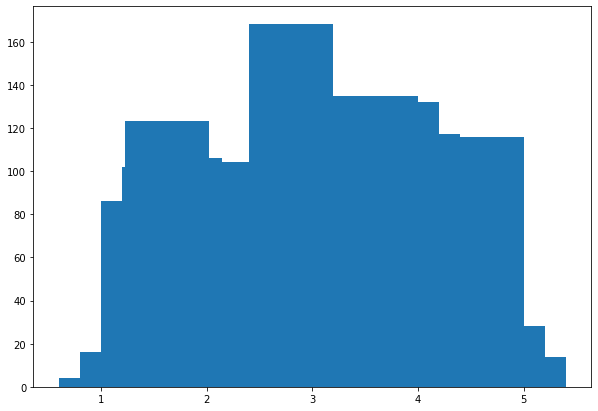

In [19]:

import pandas as pd
from matplotlib import pyplot as plt
 
 
# Figure Size
fig = plt.figure(figsize =(10, 7))
 
# Horizontal Bar Plot
plt.bar(nisqa["mos"].unique(), nisqa["mos"].value_counts())

In [24]:
nisqa["pesq"].min()

1.020658016204834

ValueError: shape mismatch: objects cannot be broadcast to a single shape

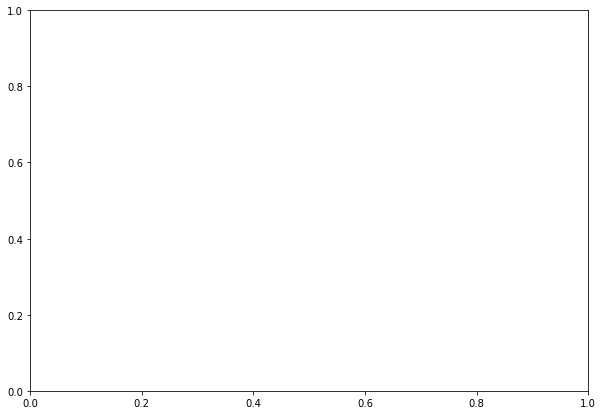

In [22]:
ranges = [0,1,2,3,4,5]
df.groupby(pd.cut(df.a, ranges)).count()
# Figure Size
fig = plt.figure(figsize =(10, 7))
 
# Horizontal Bar Plot
plt.bar(nisqa["pesq"].unique(), nisqa["pesq"].value_counts())